<a href="https://colab.research.google.com/github/cacress/Exploration-of-Streaming-Metadata-CSC-442/blob/main/notebooks/Rithik_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of observations after popularity filtering: 717
Number of observations after genre filtering: 717


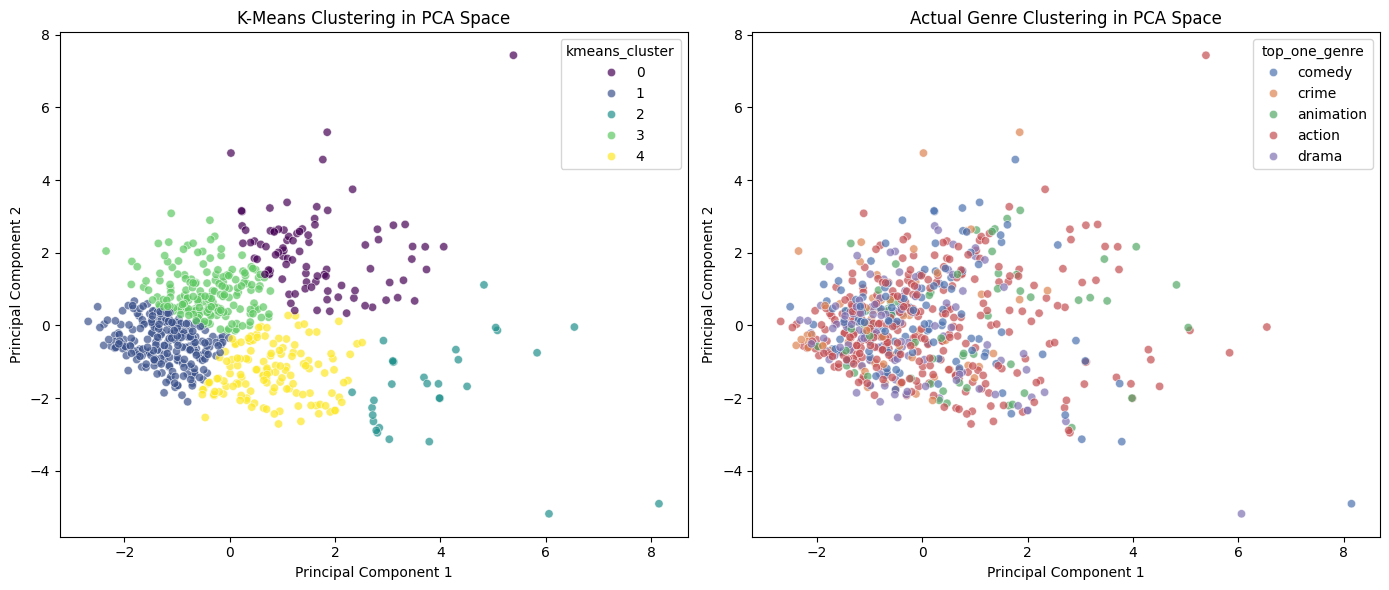

Adjusted Rand Index (ARI): -0.0022628851653600335
Normalized Mutual Information (NMI): 0.019425026448645924


In [ ]:
# The following code does a K-means cluster to represent an "expected" clustering of the filtered data in a PCA space based on text metrics.
# Then, in the same PCA space, it generates a genre-based clustering, which we treat as our "observed" clustering.
# Finally, it calculates the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) to get an objective analysis of the similarity between the two clusterings.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/cacress/CSC442/refs/heads/rithik_eda/datasets/rithik_eda_dataset.csv')

# Filter for popular productions and check # values in subset
df = df[df['tmdb_popularity'] >= 50]
print("Number of observations after popularity filtering:", df.shape[0])

# Define the text metric features and include the existing genre column
features = [
    'description_sentiment', 'title_sentiment',
    'description_neutrality', 'title_neutrality',
    'description_ari', 'title_ari',
    'description_word_count', 'title_word_count',
    'description_character_count', 'title_character_count'
]

# Ensure the neutrality columns are present. If not, calculate them
if 'description_neutrality' not in df.columns:
    df['title_neutrality'] = 1 - df['title_sentiment'].abs()
    df['description_neutrality'] = 1 - df['description_sentiment'].abs()

# Filter for missing values and for genres with sufficient data remaining
data = df[features + ['top_one_genre']].dropna().copy()
genre_counts = data['top_one_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index
data = data[data['top_one_genre'].isin(valid_genres)]
print("Number of observations after genre filtering:", df.shape[0])

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data['pca1'] = pca_result[:, 0]
data['pca2'] = pca_result[:, 1]

# K-means clustering inside the new PCA space
# Use the number of clusters equal to the number of unique genres
unique_genres = data['top_one_genre'].unique()
k = len(unique_genres)
kmeans = KMeans(n_clusters=k, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(pca_result)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot K-means clustering in PCA space
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=data, palette='viridis', alpha=0.7, ax=axes[0])
axes[0].set_title('K-Means Clustering in PCA Space')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot actual genres clustering in the PCA space
sns.scatterplot(x='pca1', y='pca2', hue='top_one_genre', data=data, palette='deep', alpha=0.7, ax=axes[1])
axes[1].set_title('Actual Genre Clustering in PCA Space')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

# Statistical analysis of similarity between clusterings
# Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
ari = adjusted_rand_score(data['top_one_genre'], data['kmeans_cluster'])
nmi = normalized_mutual_info_score(data['top_one_genre'], data['kmeans_cluster'])
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
